# House Numbers Prediction Using PyTorch
### by Yuliya Klimushina 2019
In this work I demonstrate how using Batch Normalization, learning rate adjusting and choosing the right optimization method can significantly improve the performance of a model. This work was done during completing the course "Deep Learning" by Simon Kozlov (https://dlcourse.ai/).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

Let's load the dataset. PyTorch consists plenty of datasets in torchvision.datasets module including SVHN.

In [2]:
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True)

Now let's split the dataset to the training and validation parts using `SubsetRandomSampler` и `DataLoader`.

`DataLoader` is a class that loads data and groups it to batches.
One of its parameters refers to a `Sampler` class that defines which examples to use for training or validation. 

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(validation_split * data_size)
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

The dataset is a set of 3-D images. We'll use a spetial module to shape it into a 1-D tensor

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


The main objects of PyTorch:
- `nn_model` - neural network model,
- `loss` - loss function, in this case `CrossEntropyLoss`
- `optimizer` - optimization algorithm, in this case `SGD`

The function below implements the train loop in PyTorch.
Every epoch it calculates the accuracy on the validation dataset.

In [24]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            
            loss_value = loss(prediction, y)
            optimizer.zero_grad()  #set gradients to zero
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler:
            scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples    
    return accuracy


Here we create a simple model with 2 hidden layers of the size 100 and Relu as non-linearity.

In [10]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)
# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.172824, Train accuracy: 0.194605, Val accuracy: 0.228722
Average loss: 2.003180, Train accuracy: 0.275091, Val accuracy: 0.345301
Average loss: 1.792876, Train accuracy: 0.385660, Val accuracy: 0.418606
Average loss: 1.699801, Train accuracy: 0.423728, Val accuracy: 0.432667
Average loss: 1.676037, Train accuracy: 0.436935, Val accuracy: 0.442154


Let's add Batch Normalization layers before non-linearity.

In [11]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.747892, Train accuracy: 0.459322, Val accuracy: 0.542693
Average loss: 1.617190, Train accuracy: 0.547350, Val accuracy: 0.586103
Average loss: 1.664322, Train accuracy: 0.541310, Val accuracy: 0.489864
Average loss: 1.693151, Train accuracy: 0.528564, Val accuracy: 0.527268
Average loss: 1.707537, Train accuracy: 0.511654, Val accuracy: 0.521671


Let's add a scheduler that decrease learning rate during training.  

In [26]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 
                                                     5, scheduler)

Average loss: 1.927047, Train accuracy: 0.379637, Val accuracy: 0.557163
Average loss: 1.500251, Train accuracy: 0.594700, Val accuracy: 0.629377
Average loss: 1.344794, Train accuracy: 0.652476, Val accuracy: 0.663641
Average loss: 1.279653, Train accuracy: 0.671365, Val accuracy: 0.686779
Average loss: 1.222870, Train accuracy: 0.689708, Val accuracy: 0.704184


# Visualizing model errors

Let's try to see which images our model is wrong on.
To do this, we will get all the model predictions on the validation set and compare them with the true labels (ground truth).


In [27]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
  
    # Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    x = torch.Tensor(dataset.data[indices])
    y = torch.Tensor(dataset.labels[indices])
    ground_truth = y.type(torch.ByteTensor)
    predictions = model(x)
    predictions = torch.argmax(predictions.data, 1).type(torch.ByteTensor)
    accuracy = torch.sum(ground_truth == predictions) / len(indices)
    return predictions.numpy(), ground_truth.numpy()

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)

## Confusion matrix

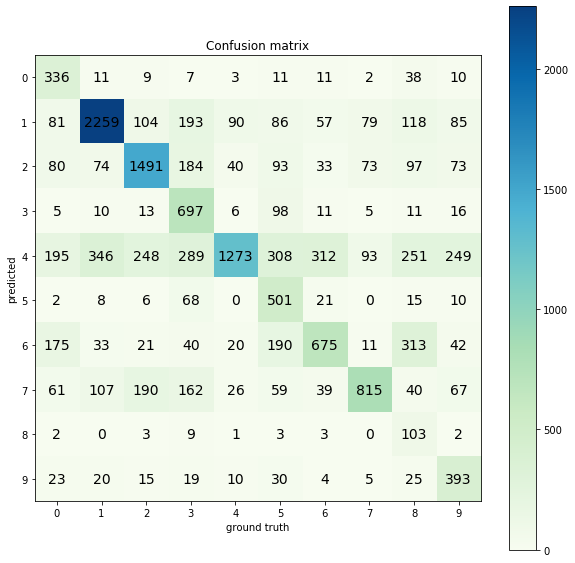

In [28]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    unique_pairs = np.unique(list(zip(predictions, gt)), axis=0, return_counts=True)
    for i in range(len(unique_pairs[0])):
        confusion_matrix[unique_pairs[0][i][0], unique_pairs[0][i][1]] = unique_pairs[1][i]
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

The system makes the most mistakes when trying to predict the number 4.

Let's visualize the most common mistakes and try to understand why the model makes them.

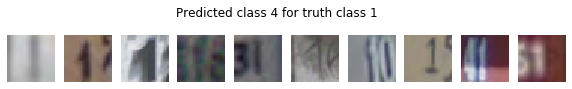

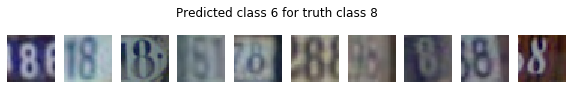

In [30]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    preds_gt = np.array(list(zip(predictions, gt)))
    indices = np.all(preds_gt == [predicted_class, gt_class], axis=1).nonzero()[0]
    visualize_images(val_indices[indices], data, 
                     title='Predicted class %s for truth class %s' % (predicted_class, gt_class), max_num=10)

visualize_predicted_actual(4, 1, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)

Now let's use a slight variation of normal gradient descent called Nesterov momentum.

In [32]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 
                                                       30)

Average loss: 1.422821, Train accuracy: 0.552025, Val accuracy: 0.675858
Average loss: 0.989448, Train accuracy: 0.695338, Val accuracy: 0.718381
Average loss: 0.856629, Train accuracy: 0.733816, Val accuracy: 0.754078
Average loss: 0.776692, Train accuracy: 0.758830, Val accuracy: 0.763634
Average loss: 0.724105, Train accuracy: 0.775501, Val accuracy: 0.789161
Average loss: 0.679731, Train accuracy: 0.787872, Val accuracy: 0.787455
Average loss: 0.654968, Train accuracy: 0.796847, Val accuracy: 0.803631
Average loss: 0.624249, Train accuracy: 0.805481, Val accuracy: 0.805338
Average loss: 0.598528, Train accuracy: 0.812784, Val accuracy: 0.808272
Average loss: 0.582208, Train accuracy: 0.818807, Val accuracy: 0.813323
Average loss: 0.561532, Train accuracy: 0.824045, Val accuracy: 0.811480
Average loss: 0.554362, Train accuracy: 0.827219, Val accuracy: 0.819261
Average loss: 0.535629, Train accuracy: 0.833259, Val accuracy: 0.816941
Average loss: 0.524874, Train accuracy: 0.835529, V

And let's check the accuracy on the test dataset.

In [26]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8283
